# 处理链接为：https://zenodo.org/records/4399187 的数据

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

file_path = "/Users/taochen/coder/code/TOA/datasets/6611037/dataset.pkl"
# Extract dataset
dataset = pd.read_pickle(file_path)

ds = dataset

# 将 CIR 列中的 array 转换为 list
ds["CIR"] = ds["CIR"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
# 添加 TOA 列
ds["TOA"] = (ds["Range"] - ds["Error"]) / 3e8 * 1e9

# save ds
ds.to_csv(file_path.replace("pkl", "csv"))


# 处理链接为：https://log-a-tec.eu/uwb-ds.html 的数据

In [ ]:
import os
import csv
import random
import pandas as pd

def load_uwb_csv(filename):
    rows = []
    with open(filename, "r") as f:
        reader = csv.reader(f)
        next(reader)  # 跳过第一行 v1.1
        header = next(reader)  # 读取列名行
        
        # 找到 CIR 列的位置
        cir_idx = header.index("CIR...")
        
        for row in reader:
            # 前面固定字段
            fixed = row[:cir_idx+1]  
            
            # CIR 部分：把后面所有的复数字符串转成真正的 complex
            cir_raw = row[cir_idx:]
            cir_values = []
            for val in cir_raw:
                if val.strip():  # 跳过空字符串
                    try:
                        cir = complex(val.replace(" ", ""))
                        cir_values.append(abs(cir))
                    except ValueError:
                        pass  # 有些异常值可以选择忽略
            
            # 组装结果：把 CIR 存成 list
            rows.append(fixed[:-1] + [cir_values])  # 把 CIR...列替换成 CIR list
    
    # 构造 DataFrame
    columns = header[:cir_idx] + ["CIR"]
    df = pd.DataFrame(rows, columns=columns)
    # 添加 TOA 列
    df["TOA"] = df["FP_INDEX"]
    # 丢弃TOA < 10的行，确保 TOA 列为数值型
    df["TOA"] = pd.to_numeric(df["TOA"], errors="coerce")
    df = df[df["TOA"] >= 10].reset_index(drop=True)
    # 截取TOA前后100对应CIR的点，然后随机插入CIR的其余位置，并保住总长度为300
    def process_cir_and_toa(cir, toa, window=100, total_len=300):
        toa = int(round(toa))
        cir = list(cir)
        left = max(0, toa - window)
        right = min(len(cir), toa + window)
        main = cir[left:right]
        others = cir[:left] + cir[right:]
        need = total_len - len(main)
        result = [0.0] * total_len
        if need > 0:
            if len(others) >= need:
                extra = random.sample(others, need)
            else:
                extra = others + [0.0] * (need - len(others))
            fill = main + extra
        else:
            fill = main[:total_len]
        start = random.randint(0, total_len - len(main))
        result[start:start+len(main)] = main
        fill_idx = 0
        for i in range(total_len):
            if result[i] == 0.0 and fill_idx < len(fill) - len(main):
                result[i] = fill[len(main) + fill_idx]
                fill_idx += 1
        new_toa = start + (toa - left) + 1
        return result, new_toa

    cir_toa_list = [process_cir_and_toa(row["CIR"], row["TOA"]) for _, row in df.iterrows()]
    df["CIR"] = [item[0] for item in cir_toa_list]
    df["TOA"] = [item[1] for item in cir_toa_list]

    return df

def process_and_save_all_csv(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".csv"):
                in_path = os.path.join(root, file)
                out_path = os.path.join(output_dir, os.path.basename(root), file)
                df = load_uwb_csv(in_path)
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                if not df.empty:
                    df.to_csv(out_path, index=False)
                    print(f"Processed and saved: {out_path}")

input_dir = "/Users/taochen/coder/code/TOA/datasets/data/office/measurements"
output_dir = "/Users/taochen/coder/code/TOA/datasets/data/office/industrial"


process_and_save_all_csv(input_dir, output_dir)


# 拆分数据集

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def merge_csvs_in_dir(input_dir):
    dfs = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root, file))
                dfs.append(df)
    if dfs:
        merged_df = pd.concat(dfs, ignore_index=True)
        return merged_df
    else:
        return None

def split_and_save_df(df, output_dir):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    os.makedirs(output_dir, exist_ok=True)
    train.to_csv(os.path.join(output_dir, f"train.csv"), index=False)
    val.to_csv(os.path.join(output_dir, f"val.csv"), index=False)
    test.to_csv(os.path.join(output_dir, f"test.csv"), index=False)

def split_csvs_in_dir(input_path, output_dir):
    if os.path.isfile(input_path) and input_path.endswith('.csv'):
        df = pd.read_csv(input_path)
        split_and_save_df(df, output_dir)
    else:
        merged_df = merge_csvs_in_dir(input_path)
        if merged_df is not None:
            split_and_save_df(merged_df, output_dir)

input_dir = "/Users/taochen/coder/code/TOA/datasets/data_process/"
output_dir = "/Users/taochen/coder/code/TOA/datasets/data_process/split"
# 用法示例
split_csvs_in_dir(input_dir, output_dir)

# 可视化数据

In [36]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# file_path = "/Users/taochen/coder/code/TOA/datasets/6611037/dataset.csv"
file_path = "/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/datasets_synthetic/20250917_141809.csv"
output_dir = "/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/plots"
ds = pd.read_csv(file_path)

os.makedirs(output_dir, exist_ok=True)

for i, row in ds.iterrows():
    cir = eval(row["CIR"])
    toa = row["TOA"]
    plt.figure(figsize=(10, 4))
    plt.plot(cir, label=f"CIR MAX={list(cir).index(max(cir))}")
    plt.axvline(x=toa, color='r', linestyle='--', label=f'TOA={toa:.2f}')
    plt.title(f"Random CIR Sample (Index: {i})")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.savefig(f"{output_dir}/cir_{i}.png")
    plt.close()



In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def plot_cir_with_targets(csv_path, save_path):
    os.makedirs(save_path, exist_ok=True)
    df = pd.read_csv(csv_path)
    for idx, row in df.iterrows():
        cir = eval(row["CIR"])
        target = int(row["target"])
        prediction = int(row["prediction"])
        plt.figure(figsize=(10, 4))
        plt.plot(cir, label="CIR")
        plt.axvline(x=target, color='r', linestyle='--', label=f'Target={target}')
        plt.axvline(x=prediction, color='g', linestyle='--', label=f'Prediction={prediction}')
        plt.title(f"CIR Sample (Index: {idx})")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{save_path}/cir_{idx}.png")
        plt.close()

# 用法示例
plot_cir_with_targets("results/toa_lstm_2/test_predictions.csv", "results/toa_lstm_2/test_predictions_plots")

# CDF绘制

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 使用用户提供的CDF数据
cdf_data = {
    "Peak": [1, 4, 9, 12, 24],
    "IFP": [1, 2, 6, 9, 20],
    "LDE": [1, 2, 6, 10, 21],
    "Model": [0.6066, 1.1788, 1.7888, 2.2754, 3.8422]
}

percentiles = [50, 75, 90, 95, 99]  # CDF 对应的百分位数

plt.figure(figsize=(7,5))

for method, values in cdf_data.items():
    values = list(np.array(values) * 1e-9 * 3e8) # 转换为米
    plt.plot(values, np.array(percentiles)/100, marker="o", label=method)

plt.xlabel("Ranging Error (m)")
plt.ylabel("CDF")
plt.title("CDF of Ranging Error (from percentiles)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# 合成水下数据

In [4]:
data = {
    "blue": {
        "Location": "North Atlantic",
        "Date": "Jun. 2010",
        "dT/dR/dW [m]": "30-60/50/100",
        "Mobility": "Up to 1.5m/s",
        "d [km]": "3-7",
        "fc [kHz]": 13,
        "R [kHz]": 4.8,
        "Array": "Vertical",
        "M": 12,
        "ℓ [m]": 12
    },
    "red": {
        "Location": "Singapore",
        "Date": "Nov. 2024",
        "dT/dR/dW [m]": "6/3/8",
        "Mobility": "Drifting",
        "d [km]": 0.1,
        "fc [kHz]": 25,
        "R [kHz]": 9.6,
        "Array": "Vertical",
        "M": 3,
        "ℓ [m]": 0.8
    },
    "yellow": {
        "Location": "Hawaii",
        "Date": "Jun. 2011",
        "dT/dR/dW [m]": "50/50/100",
        "Mobility": "Moored",
        "d [km]": [3, 7],
        "fc [kHz]": 13,
        "R [kHz]": 6.25,
        "Array": "Vertical",
        "M": 24,
        "ℓ [m]": [5, 20]
    },
    "purple": {
        "Location": "North Atlantic",
        "Date": "Oct. 2008",
        "dT/dR/dW [m]": "11/10/15",
        "Mobility": "Moored",
        "d [km]": [0.06, 0.2, 1],
        "fc [kHz]": 12.5,
        "R [kHz]": 10**7/1536,
        "Array": ["Cross", "Vertical"],
        "M": [32, 24, 12],
        "ℓ [m]": [3.75, 5, 12]
    },
    "green": {
        "Location": "Norway",
        "Date": "Nov. 2024",
        "dT/dR/dW [m]": "20/43/60",
        "Mobility": "Moored",
        "d [km]": [0.27, 11.52, 28],
        "fc [kHz]": [6, 11.52, 28],
        "R [kHz]": [4.5, 5.625, 9],
        "Array": "N/A",
        "M": None,
        "ℓ [m]": None
    },
    "skyblue": {
        "Location": "Earth",
        "Date": "Jan. 1990",
        "dT/dR/dW [m]": "175/?/x",
        "Mobility": "Mobile",
        "d [km]": [5513, 9192],
        "fc [kHz]": 0.057,
        "R [kHz]": 11.4,
        "Array": ["N/A", "Vertical"],
        "M": None,
        "ℓ [m]": "?"
    },
    "namikaze": {
        "Location": "Kochi Prefecture, Japan",
        "Date": "Jul. 2022",
        "dT/dR/dW [m]": "176/146/x",
        "Mobility": "Moored",
        "d [km]": 14,
        "fc [kHz]": 6,
        "R [kHz]": 4,
        "Array": "Vertical",
        "M": 24,
        "ℓ [m]": "x"
    },
    "abyssal": {
        "Location": "Mariana Trench",
        "Date": "Oct. 2024",
        "dT/dR/dW [m]": "6/8718/8720",
        "Mobility": "Moored",
        "d [km]": 8.72,
        "fc [kHz]": 12.5,
        "R [kHz]": 12.5,
        "Array": "Circular",
        "M": 8,
        "ℓ [m]": "x"
    }
}

def generate_bpsk(fc=13e3, R=2048, fs=None, duration=0.01):
    """
    生成指定持续时间的BPSK信号
    
    fc: 载波频率 (Hz)
    R: 符号速率 (symbols/s)
    fs: 采样率 (Hz)，如果不给定，取10*fc
    duration: 信号持续时间 (s)
    """
    if fs is None:
        fs = 10 * fc  # 默认采样率
    
    Ts = 1 / R                          # 符号周期
    N = int(R * duration)               # 符号数
    samples_per_symbol = int(fs / R)    # 每个符号的采样点数
    
    # 生成比特 {-1,+1}
    bits = np.random.choice([0, 1], size=N)
    symbols = 2 * bits - 1
    
    # 展开为基带信号
    baseband = np.repeat(symbols, samples_per_symbol)
    
    # 时间轴
    t = np.arange(len(baseband)) / fs
    
    # 载波
    carrier = np.cos(2 * np.pi * fc * t)
    
    # BPSK 调制
    bpsk_signal = baseband * carrier
    
    return t, bpsk_signal, bits

Start = 0


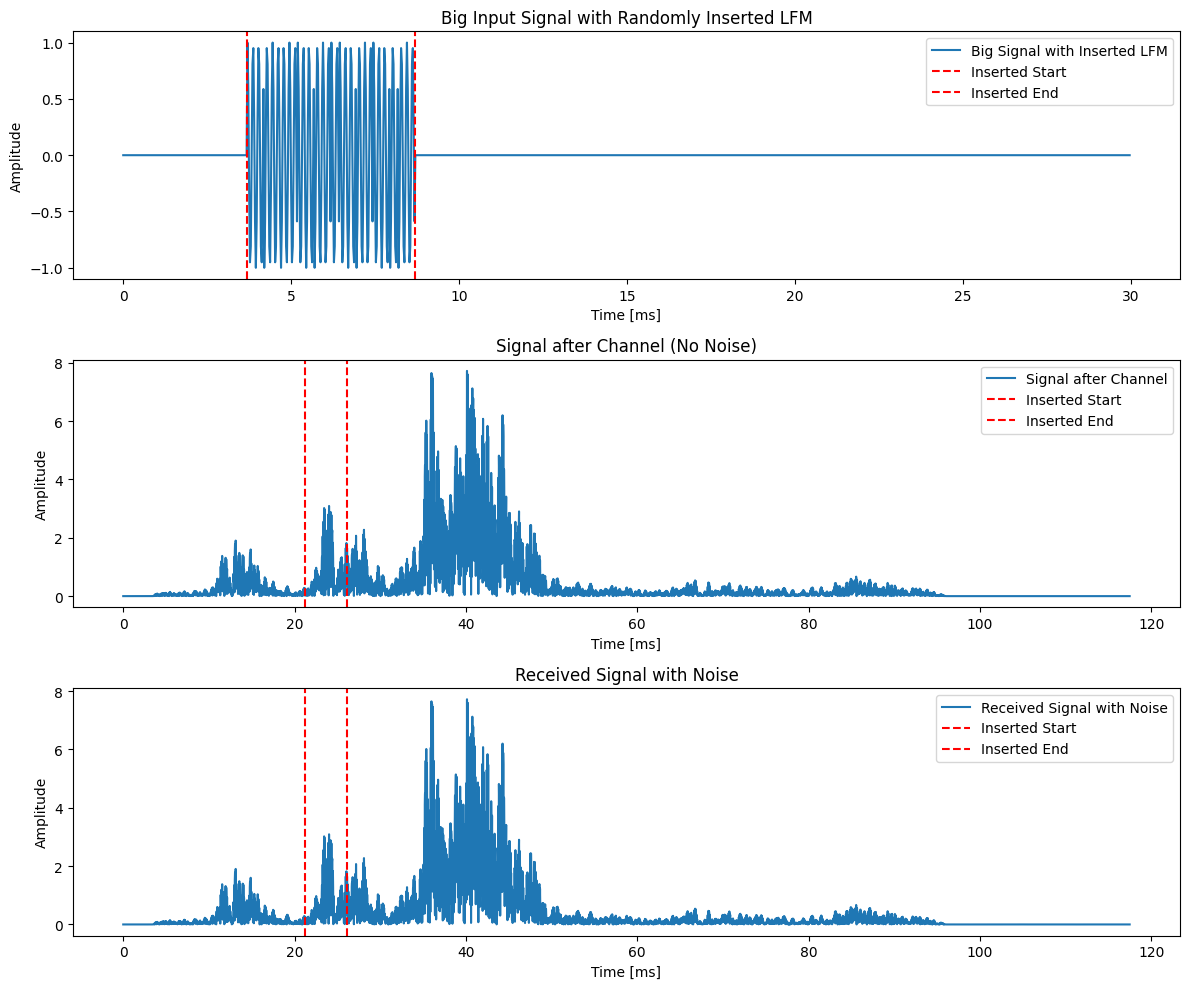

In [59]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from uwa_replay import replay, noisegen
from fractions import Fraction

# ======================
# 1. 基本参数设置
# ======================
fs = 40e3           # 采样率 80 kHz
T_sig = 0.005         # 原信号长度 10 ms
T_total = 0.03        # 总时间长度 1 s
array_index = [0]    # 阵元索引必须是 list，比如 [6]

# ======================
# 4. 载入信道和噪声数据
# ======================
channel_path = "/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/channels/namikaze_2.mat"
noise_path = "/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/noises/namikaze_2_noise.mat"
channel = h5py.File(channel_path, "r")
noise = h5py.File(noise_path, "r")

# ======================
# 2. 生成输入信号 (LFM 线性调频信号)
# ======================
# t_sig = np.arange(0, T_sig, 1/fs)
# f0, f1 = 20e3, 40e3   # LFM 起始频率 20kHz, 终止频率 40kHz
# input_signal = np.cos(2 * np.pi * (f0 * t_sig + (f1 - f0) / (2 * T_sig) * t_sig**2))

name = os.path.basename(channel_path).split("_")[0].split(".")[0].lower()
idx = int(os.path.basename(channel_path).split("_")[1].split(".")[0]) if len(os.path.basename(channel_path).split("_")) > 1 else 0
meta = data[name]
fc = meta["fc [kHz]"][idx] * 1e3 if isinstance(meta["fc [kHz]"], list) else meta["fc [kHz]"] * 1e3
R = meta["R [kHz]"][idx] * 1e3 if isinstance(meta["R [kHz]"], list) else meta["R [kHz]"] * 1e3
# 示例：使用 Blue 集的参数 (fc=13 kHz, R≈2048)
t_sig, input_signal, bits = generate_bpsk(fc=fc, fs=fs, R=R, duration=T_sig)

# ======================
# 3. 构造大信号并随机插入
# ======================
N_total = int(T_total * fs)       # 总样本数
big_signal = np.zeros(N_total)    # 初始化全零
N_sig = len(input_signal)         # 原信号长度
start_idx = np.random.randint(0, N_total - N_sig)  # 随机插入位置
big_signal[start_idx:start_idx+N_sig] = input_signal
t_total = np.arange(N_total) / fs

# print(f"Signal inserted at index: {start_idx} ({start_idx/fs*1e3:.2f} ms)")


# ======================
# 5. 信道仿真
# ======================
y = replay(big_signal, fs, array_index, channel, start=0)
y = np.abs(y)  # 取绝对值
# ======================
# 6. 加入噪声
# ======================
w = noisegen(y.shape, fs, array_index, noise)
r = y + 0.05 * w   # 控制噪声强度

# ======================
# 7. 绘图对比
# ======================
plt.figure(figsize=(12, 10))

# 原始大信号
plt.subplot(3, 1, 1)
plt.plot(t_total*1e3, big_signal, label="Big Signal with Inserted LFM")
plt.axvline(start_idx/fs*1e3, color='r', linestyle='--', label="Inserted Start")
plt.axvline((start_idx+N_sig)/fs*1e3, color='r', linestyle='--', label="Inserted End")
plt.title("Big Input Signal with Randomly Inserted LFM")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.legend()

L = channel['h_hat']['real'].shape[2]  # 信道 taps
start_idx = start_idx + (L - 1)  # 修正插入位置
end_idx = start_idx + N_sig + (L - 1)

# # 信道脉冲响应长度
# L = channel['h_hat']['real'].shape[2]
# # 采样率比例 (fs_delay / fs)
# frac = Fraction(channel["params"]["fs_delay"][0, 0] / fs).limit_denominator()
# # 插入点在输出信号中的位置
# start_idx = start_idx + (L - 1) * frac.numerator / frac.denominator
# end_idx   = start_idx + N_sig + (L - 1) * frac.numerator / frac.numerator

# frac = len(y) / len(big_signal)
# start_idx = start_idx + int((L-1) * frac)
# end_idx = start_idx + N_sig + int((L-1) * frac)

# 信号通过信道后的接收信号（无噪声）
plt.subplot(3, 1, 2)
plt.plot(np.arange(len(y))/fs*1e3, y[:, 0], label="Signal after Channel")
plt.axvline(start_idx/fs*1e3, color='r', linestyle='--', label="Inserted Start")
plt.axvline((start_idx+N_sig)/fs*1e3, color='r', linestyle='--', label="Inserted End")
plt.title("Signal after Channel (No Noise)")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.legend()

# 加噪声后的接收信号
plt.subplot(3, 1, 3)
plt.plot(np.arange(len(r))/fs*1e3, r[:, 0], label="Received Signal with Noise")
plt.axvline(start_idx/fs*1e3, color='r', linestyle='--', label="Inserted Start")
plt.axvline((start_idx+N_sig)/fs*1e3, color='r', linestyle='--', label="Inserted End")
plt.title("Received Signal with Noise")
plt.xlabel("Time [ms]")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
import h5py
import numpy as np
import os
import csv
import time
from uwa_replay import replay, noisegen


# ======================
# 1. 定义信号生成器
# ======================
def generate_signal(signal_type, fs, T_sig, f0, f1=None):
    t = np.arange(0, T_sig, 1/fs)
    if signal_type == "LFM":
        return np.cos(2*np.pi*(f0*t + (f1-f0)/(2*T_sig)*t**2))
    elif signal_type == "Tone":
        return np.cos(2*np.pi*f0*t)
    elif signal_type == "ChirpUp":
        return np.cos(2*np.pi*(f0*t + (f1-f0)/(2*T_sig)*t**2))  # 上扫频
    elif signal_type == "ChirpDown":
        return np.cos(2*np.pi*(f1*t - (f1-f0)/(2*T_sig)*t**2))  # 下扫频
    elif signal_type == "BPSK":
        bits = np.random.choice([-1, 1], size=len(t))
        return np.cos(2*np.pi*f0*t) * bits
    elif signal_type == "NoiseBurst":
        return np.random.randn(len(t))
    else:
        raise ValueError(f"未知信号类型: {signal_type}")


# ======================
# 2. 单样本生成
# ======================
def generate_sample(
    fs,
    T_sig,
    T_total,
    signal_type,
    f0,
    f1,
    channel_file,
    noise_file,
    array_index=[0],
    noise_scale=0.05,
):
    input_signal = generate_signal(signal_type, fs, T_sig, f0, f1)

    N_total = int(T_total * fs)
    big_signal = np.zeros(N_total)
    N_sig = len(input_signal)
    start_idx = np.random.randint(0, N_total - N_sig)
    big_signal[start_idx:start_idx+N_sig] = input_signal

    channel = h5py.File(channel_file, "r")
    noise = h5py.File(noise_file, "r")

    y = replay(big_signal, fs, array_index, channel, start=0)
    w = noisegen(y.shape, fs, array_index, noise)
    r = y + noise_scale * w

    return {
        "signal_type": signal_type,
        "f0": f0,
        "f1": f1,
        "T_sig": T_sig,
        "T_total": T_total,
        "start_idx": start_idx,
        "noise_scale": noise_scale,
        "channel_file": os.path.basename(channel_file),
        "noise_file": os.path.basename(noise_file),
        "array_index": int(array_index[0]),
        "CIR": np.abs(r[:, 0]).tolist(),
    }


# ======================
# 3. 数据集生成
# ======================
def generate_dataset(
    output_dir,
    fs=500e3,
    T_sig=0.001,
    T_total=0.003,
    signal_types=["LFM", "Tone", "ChirpUp", "ChirpDown", "BPSK", "NoiseBurst"],
    f0_list=[20e3, 30e3, 40e3],
    f1_list=[40e3, 50e3, 60e3],
    noise_scales=[0.01, 0.05, 0.1],
    channel_dir="channels/",
    noise_dir="noises/",
    N=1000,
    chunk_size=100,
):
    os.makedirs(output_dir, exist_ok=True)
    channel_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.endswith(".mat")]

    buffer = []
    for i in range(N):
        signal_type = np.random.choice(signal_types)
        f0 = np.random.choice(f0_list)
        f1 = np.random.choice(f1_list)
        fs = 2 * f1
        noise_scale = np.random.choice(noise_scales)
        channel_file = np.random.choice(channel_files)
        noise_file = channel_file.replace("channels", "noises").replace(".mat", "_noise.mat")

        channel = h5py.File(channel_file, "r")
        array_indexs = list(range(channel["h_hat"]["real"].shape[1]))
        array_index = [np.random.choice(array_indexs)]

        sample = generate_sample(
            fs, T_sig, T_total,
            signal_type, f0, f1,
            channel_file, noise_file,
            array_index=array_index,
            noise_scale=noise_scale
        )

        buffer.append([
            sample["signal_type"],
            sample["f0"],
            sample["f1"],
            sample["T_sig"],
            sample["T_total"],
            sample["noise_scale"],
            sample["channel_file"],
            sample["noise_file"],
            sample["array_index"],
            sample["start_idx"],
            sample["CIR"]
        ])

        # 每 chunk_size 保存一次
        if (i + 1) % chunk_size == 0:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            file_path = os.path.join(output_dir, f"{timestamp}.csv")
            with open(file_path, mode="w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["signal_type", "f0", "f1", "T_sig", "T_total", "noise_scale",
                                 "channel_file", "noise_file", "array_index", "TOA", "CIR"])
                writer.writerows(buffer)
            print(f"✅ 已保存 {i+1} 条样本到 {file_path}")
            buffer = []  # 清空缓冲区


# ======================
# 4. 调用
# ======================
generate_dataset(
    output_dir="/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/datasets_synthetic",
    channel_dir="/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/channels/",
    noise_dir="/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/noises/",
    N=1000,          # 生成总样本数
    chunk_size=20,   # 每20条保存一次
    noise_scales=list(np.arange(0.00, 10, 0.005))
)

Start = 0


/opt/homebrew/Caskroom/miniconda/base/envs/toa/lib/python3.10/site-packages/uwa_replay/noisegen.py:86: RuntimeWarning: divide by zero encountered in matmul
  n = np.random.randn(
/opt/homebrew/Caskroom/miniconda/base/envs/toa/lib/python3.10/site-packages/uwa_replay/noisegen.py:86: RuntimeWarning: overflow encountered in matmul
  n = np.random.randn(
/opt/homebrew/Caskroom/miniconda/base/envs/toa/lib/python3.10/site-packages/uwa_replay/noisegen.py:86: RuntimeWarning: invalid value encountered in matmul
  n = np.random.randn(


Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
✅ 已保存 20 条样本到 /Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/datasets_synthetic/20250917_141809.csv
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0
Start = 0


KeyboardInterrupt: 

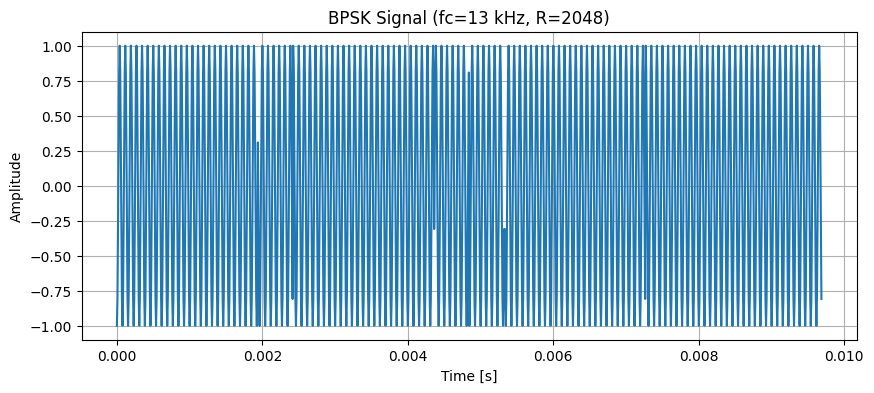

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def generate_bpsk(fc=13e3, R=2048, fs=None, N=100):
    """
    生成BPSK信号
    fc: 载波频率 (Hz)
    R: 码元速率 (symbols/s)
    fs: 采样率 (Hz)，如果不给定，取10*fc
    N: 符号数
    """
    if fs is None:
        fs = 10 * fc  # 默认采样率
    Ts = 1 / R       # 符号周期
    samples_per_symbol = int(fs / R)  # 每个符号的采样点数
    
    # 生成随机比特 {-1, +1}
    bits = np.random.choice([0, 1], size=N)
    symbols = 2*bits - 1  # 映射到 {-1, +1}
    
    # 展开符号序列
    baseband = np.repeat(symbols, samples_per_symbol)
    
    # 时间轴
    t = np.arange(len(baseband)) / fs
    
    # 载波
    carrier = np.cos(2 * np.pi * fc * t)
    
    # BPSK调制
    bpsk_signal = baseband * carrier
    
    return t, bpsk_signal, bits

# 示例：使用 Blue 集的参数 (fc=13 kHz, R≈2048)
t, bpsk, bits = generate_bpsk(fc=13e3, R=2048, N=20)

# 绘制波形
plt.figure(figsize=(10,4))
plt.plot(t[:2000], bpsk[:2000])  # 只画前2000个点
plt.title("BPSK Signal (fc=13 kHz, R=2048)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import scipy.signal as sg
import h5py
import matplotlib.pyplot as plt
from uwa_replay import replay, noisegen

# ------------------------
# 参数设置
# ------------------------
fs = 48e3       # 采样率
fc = 13e3       # 载波频率
R = 4e3         # 符号率
array_index = np.array([0])  # 通道索引
toa_sec = 0.05               # 指定 TOA 50ms
noise_amp = 0.05

# ------------------------
# 生成随机BPSK信号
# ------------------------
data_symbols = np.random.choice([-1.0, +1.0], size=(1023,))
baseband = sg.resample_poly(np.tile(data_symbols, 1), fs / R, 1)
passband = np.real(baseband * np.exp(2j * np.pi * fc * np.arange(len(baseband)) / fs))
input_signal = np.concatenate((np.zeros((int(fs/10),)), passband, np.zeros(int(fs/10))))

# ------------------------
# 打开信道文件
# ------------------------
channel = h5py.File("/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/blue/blue_1.mat", "r")
noise = h5py.File("/Users/taochen/coder/code/TOA/datasets/Underwater_Acoustic_Channels/blue/blue_1_noise.mat", "r")

# ------------------------
# 计算start索引以对应TOA
# ------------------------
fs_delay = channel["params"]["fs_delay"][0,0]
start_index = int(toa_sec * fs_delay)

# ------------------------
# 仿真信号
# ------------------------
output_signal = replay(input_signal, fs, array_index, channel, start=start_index)
# output_signal += noise_amp * noisegen(output_signal.shape, fs, array_index, noise)

# ------------------------
# 下变频得到基带CIR
# ------------------------
v = output_signal * np.exp(-2j * np.pi * fc * np.arange(output_signal.shape[0])[:, None] / fs)
cir = np.abs(v[:, 0])

# ------------------------
# 绘图验证TOA位置
# ------------------------
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(cir))/fs, cir, label="CIR magnitude")
plt.axvline(x=toa_sec, color='r', linestyle='--', label="Expected TOA")
plt.xlabel("Time [s]")
plt.ylabel("CIR amplitude")
plt.title("CIR with Specified TOA")
plt.legend()
plt.grid()
plt.show()

# plot original signal
plt.figure()
plt.plot(np.arange(input_signal.shape[0]) / fs, input_signal)
plt.xlabel("Time [s]")
plt.ylabel("Original signal")
plt.title("Original Signal")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 参数设置
# -----------------------------
bit_seq = [1, 0, 1, 1, 0]  # 示例比特序列
A = 1                       # 载波幅度
fc = 5                       # 载波频率 (Hz)
Tb = 1                        # 每比特时间 (s)
fs = 100                      # 采样率 (Hz)

# -----------------------------
# 生成BPSK波形
# -----------------------------
t = np.arange(0, Tb*len(bit_seq), 1/fs)  # 总时间轴
s = np.zeros_like(t)                      # 初始化信号数组

for i, bit in enumerate(bit_seq):
    start = int(i*Tb*fs)
    end = int((i+1)*Tb*fs)
    if bit == 0:
        s[start:end] = A * np.cos(2*np.pi*fc*t[start:end])
    else:
        s[start:end] = -A * np.cos(2*np.pi*fc*t[start:end])  # 相位180度

# -----------------------------
# 绘制波形
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(t, s, label='BPSK Signal')
plt.title('BPSK 波形示例')
plt.xlabel('时间 (s)')
plt.ylabel('幅度')
plt.grid(True)
plt.ylim(-1.5*A, 1.5*A)
plt.show()

# 临时代码

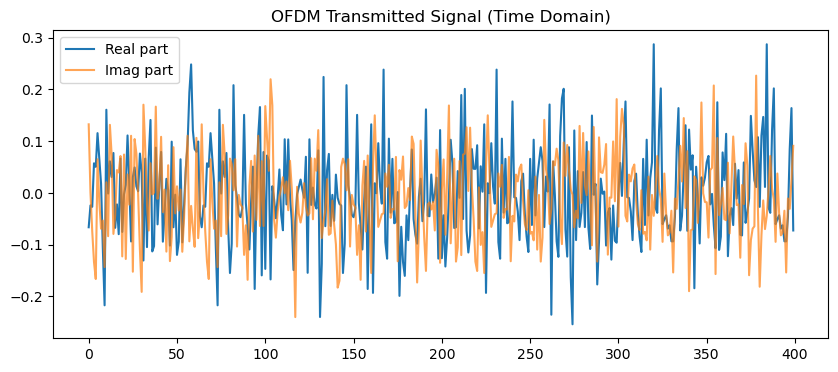

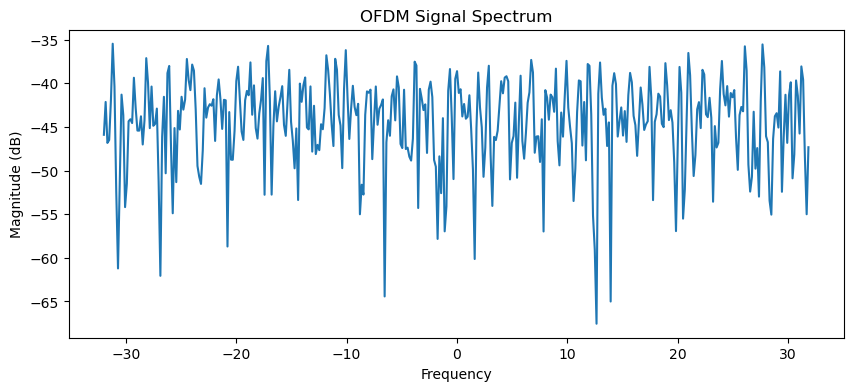

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------
# 1. 参数设置
# ---------------------
N = 64                # 子载波数
cp_len = 16           # 循环前缀长度
num_symbols = 5       # OFDM 符号个数
M = 4                 # QPSK调制 (M=4)

# ---------------------
# 2. 生成随机比特 & QPSK调制
# ---------------------
bits = np.random.randint(0, 2, num_symbols * N * int(np.log2(M)))
symbols = (2*bits[0::2]-1) + 1j*(2*bits[1::2]-1)  # QPSK符号
symbols /= np.sqrt(2)  # 归一化能量

# ---------------------
# 3. 映射到子载波 & IFFT
# ---------------------
ofdm_symbols = []
for i in range(num_symbols):
    Xk = np.zeros(N, dtype=complex)
    Xk[:] = symbols[i*N:(i+1)*N]  # 简单把每个符号映射到所有子载波
    x_time = np.fft.ifft(Xk, N)   # IFFT 得到时域
    # 添加循环前缀
    x_cp = np.concatenate([x_time[-cp_len:], x_time])
    ofdm_symbols.append(x_cp)

tx_signal = np.concatenate(ofdm_symbols)  # 串行化

# ---------------------
# 4. 可视化
# ---------------------
plt.figure(figsize=(10,4))
plt.plot(np.real(tx_signal), label="Real part")
plt.plot(np.imag(tx_signal), label="Imag part", alpha=0.7)
plt.title("OFDM Transmitted Signal (Time Domain)")
plt.legend()
plt.show()

# 画一个频谱
plt.figure(figsize=(10,4))
plt.magnitude_spectrum(tx_signal, Fs=N, scale='dB')
plt.title("OFDM Signal Spectrum")
plt.show()